Import MDAnalysis Module (https://www.mdanalysis.org/) and Matplotlib <br/> 
Don't forget to add the permissions: <br/>
sudo jupyter-nbextension enable nglview --py --sys-prefix <br/>
sudo  jupyter-nbextension enable --py widgetsnbextension <br/>

In [1]:
%matplotlib nbagg
%matplotlib inline
import MDAnalysis as mda
import MDAnalysis.analysis.leaflet
import matplotlib
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import nglview as nv

import warnings
warnings.filterwarnings('ignore')

# indicate the name of the simulation, the path of the data and the .gro and .xtc files to import
# no GM1

name = '_DPPC_DIPC_chol_352'

path = '/home/julie/analysis/bilayers/3-5-2/DPPC_DIPC_chol/'
fgro = 'run_DPPC_DIPC_CHOL_43nm_352_mb_fixed_t1_ref9999ns.gro'
fxtc = 'run_DPPC_DIPC_CHOL_43nm_352_mb_fixed_t1.xtc'

# indicate the name of the simulation, the path of the data and the .gro and .xtc files to import
# 5% GM1

name = '_DPPC_DIPC_chol_352_5GM1'

path = '/home/julie/analysis/bilayers/3-5-2/DPPC_DIPC_chol_GM1_5/'

fgro = 'run_DPPC_DIPC_CHOL_GM1_5_43nm_10ms_mb_fixed_t1_ref9999ns.gro'
fxtc = 'run_DPPC_DIPC_CHOL_GM1_5_43nm_10ms_mb_fixed_t1.xtc'

In [2]:
# name and files for the simulation studied LPT - no GM1

name = '_DPPC_DIPC_chol_352'

path = '/users/cornet/Documents/PhD/Matthieu/3-5-2/sans_GM1/'
path_res = '/users/cornet/Documents/PhD/Matthieu/3-5-2/sans_GM1/line_tension/'

fgro = 'run_DPPC_DIPC_CHOL_43nm_352_mb_fixed_t1_ref9999ns.gro'
fxtc = 'run_DPPC_DIPC_CHOL_43nm_352_mb_fixed_t1.xtc'

# name and files for the simulation studied LPT - 5% GM1

name = '_DPPC_DIPC_chol_352_5GM1'

path = '/users/cornet/Documents/PhD/Matthieu/3-5-2/5_GM1/'

fgro = 'run_DPPC_DIPC_CHOL_GM1_5_43nm_10ms_mb_fixed_t1_ref9999ns.gro'
fxtc = 'run_DPPC_DIPC_CHOL_GM1_5_43nm_10ms_mb_fixed_t1.xtc'

# name and files for the simulation studied LPT - 10% GM1

name = '_DPPC_DIPC_chol_352_5GM1'

path = '/users/cornet/Documents/PhD/Matthieu/3-5-2/10_GM1/'
path_res = '/users/cornet/Documents/PhD/Matthieu/3-5-2/10_GM1/line_tension/'

fgro = 'run_DPPC_DIPC_CHOL_GM1_10_43nm_10ms_mb_fixed_t1_ref9999ns.gro'
fxtc = 'run_DPPC_DIPC_CHOL_GM1_10_43nm_10ms_mb_fixed_t1.xtc'

Load xtc and gro files using mda.Universe('struct file','traj file')

In [3]:
u = mda.Universe( path+fgro, path+fxtc)

In [4]:
sel_all = u.select_atoms("all and (name PO4 or name GM5)")

In [5]:
# visualize the bilayer and choose the frame to study

v= nv.show_mdanalysis(sel_all)
v.add_spacefill(sel_all, scale=2.0)
v

A Jupyter Widget

In [6]:
# Leaflet separation

sel_tot = "all and (name PO4 or name GM5)"

u.trajectory[2]
Lf = mda.analysis.leaflet.LeafletFinder(u, 'name PO4 or name GM5')
leaflet0 = Lf.groups(0)
leaflet1 = Lf.groups(1)

l0 = leaflet0.select_atoms(sel_tot).positions
l1 = leaflet1.select_atoms(sel_tot).positions
m_tot = u.select_atoms(sel_tot).positions

print('total number of lipids: %d' % len(m_tot))
print('number of lipids in the upper leaflet: %d + number of lipids in the lower leaflet:%d \n= %d' % (len(l0),len(l1),len(l0)+len(l1)))

if (len(m_tot) != len(l0)+len(l1) ):
    print('PROBLEM!')

total number of lipids: 4840
number of lipids in the upper leaflet: 2420 + number of lipids in the lower leaflet:2420 
= 4840


In [7]:
time_simu = 10 # microseconds
nb_frames_simu = 10000

In [8]:
def modulo(x,a,b):
    if x < a:
        x = x + (b-a)
    elif x >= b:
        x = x - (b-a)
    return x

In [12]:
tmes = 10
t_start = 8000

N = 15 # set the number of boxes into which will be divided the membrane
x_center_b = int(np.floor(N/2))
y_center_b = int(np.floor(N/2))

threshold = 0.6 # composition threshold from which the box is considered Lo, below it is considered Ld

# r and theta pie parameters
nb_r = 6
nb_theta = 8

lq = int(np.floor(nb_theta/2))+1
q = np.arange(nb_theta/2+1) # Fourier index
r_q_pow_list = [[] for r in range(lq)]

stat = 0

time = []

for ts in u.trajectory:
    
    if (ts.frame%tmes == 0 and ts.frame>=t_start):
            
        print(ts.frame)
        time.append(ts.frame/ (nb_frames_simu/time_simu))

        #determine the min and the max values of the box -------------------------------------------------------
        sel_all = "all and (name PO4 or name GM5)"
        patch = u.select_atoms(sel_all).positions

        xmax = max(patch[:,0])
        ymax = max(patch[:,1])

        xmin = min(patch[:,0])
        ymin = min(patch[:,1])
        
        #select the lipids of the different phases, Lo or Ld ----------------------------------------------------      
        sel_Lo = "all and (name PO4 and resname DPPC)"
        M_Lo = leaflet1.select_atoms(sel_Lo).positions
        for i in range(len(M_Lo)):
            M_Lo[i,2] = 1

        sel_Ld = "all and (name PO4 and resname DIPC)"
        M_Ld = leaflet1.select_atoms(sel_Ld).positions
        for i in range(len(M_Ld)):
            M_Ld[i,2] = 0

        M_coords = np.concatenate((M_Lo, M_Ld), axis = 0)
        
        # set the spatial x and y step to divide the membrane --------------------------------------------------
        dx = (xmax-xmin)/N
        dy = (ymax-ymin)/N
        
        # leaflet 1
        # divide the leaflet into a grid and calculate the concentration ratio in each box

        bary1 = []

        Mphi1_Lo = np.zeros((N,N))

        for i in range(0,N):
            xs = xmin + i*dx
            for j in range(0,N):
                ys = ymin + j*dy

                # barycenter of all molecules in each box
                sel= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+")"
                b1=leaflet1.select_atoms(sel).centroid().tolist()
                bary1.append(b1)

                # composition rates in each box
                sel_totPC= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+" and name PO4)"
                tot1PC= leaflet1.select_atoms(sel_totPC).positions
                n_tot1PC=len(tot1PC) # total number of PC

                sel_Lo= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+") and resname DPPC"
                Lo1= leaflet1.select_atoms(sel_Lo).positions
                n_Lo1=len(Lo1) # number of molecules of the Lo phase (DPPC here)

                sel_Ld= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+") and resname DIPC"
                Ld1= leaflet1.select_atoms(sel_Ld).positions
                n_Ld1=len(Ld1) # number of molecules of the Ld phase (DIPC here)

                if  n_tot1PC!=0:
                    phi1_Lo=n_Lo1/n_tot1PC
                else :
                    print('leaflet 1, empty box: i=%d and j=%d' % (i,j))

                Mphi1_Lo[i,j]=phi1_Lo

        bary1=np.array(bary1)
        
        # lower leaflet binary composition -------------------------------------------------------------------------
        Mphi1_bin = np.zeros((N,N))

        for i in range(N):
            for j in range(N):
                if Mphi1_Lo[i,j]>= threshold :
                    Mphi1_bin[i,j]=1

        # find the domain larger axis ------------------------------------------------------------------------------
        M_sum = np.zeros((N,N))

        for i in range(N):
            for j in range(N):
                M_sum[i,j] = sum(Mphi1_bin[i,:])+sum(Mphi1_bin[:,j])
        val_max = 0
        x_big = 0
        y_big = 0
        for i in range(N):
            for j in range(N):
                if M_sum[i,j]>val_max:
                    val_max = M_sum[i,j]
                    x_big = i
                    y_big = j
        
        # reunify and center the Lo domain -------------------------------------------------------------------------
        vec_cor_b = np.zeros((1,2)) # vector containing the correction to apply to center
        x_cor = x_big - x_center_b
        y_cor = y_big - y_center_b
        
        M_full = np.zeros((N,N))

        for i in range(N):
            for j in range(N):
                if Mphi1_bin[i,j]==1:
                    M_full[ modulo(i-x_cor,0,N), modulo(j-y_cor,0,N) ] = Mphi1_bin[i,j]

        vec_cor_b[0,0] = vec_cor_b[0,0] + x_cor
        vec_cor_b[0,1] = vec_cor_b[0,1] + y_cor
        
        # determine the barycenter of the domain and its width ----------------------------------------------------------------
        nb_Lo = int(np.sum(M_full))

        coords_Lo = np.zeros((nb_Lo,2))
        l = 0
        # domain barycenter
        for i in range(N):
            for j in range(N):
                if M_full[i,j] == 1 :
                    coords_Lo[l][0] = i
                    coords_Lo[l][1] = j
                    l += 1

        box_x_mean = np.mean(coords_Lo[:,0])
        box_y_mean = np.mean(coords_Lo[:,1])
        
        # domain width
        box_x_max = 0
        box_y_max = 0
# à voir
        for i in range(N):
            for j in range(N):
                if M_full[i,j]==1 and np.abs(i-box_x_mean) > box_x_max:
                    box_x_max = np.abs(i-box_x_mean)
                if M_full[i,j]==1 and np.abs(j-box_y_mean) > box_y_max:
                    box_y_max = np.abs(j-box_y_mean)
        box_max = np.ceil(max(box_x_max,box_y_max))
        
        x_mean_b = int(round(box_x_mean))
        y_mean_b = int(round(box_y_mean))
        
        # second correction to recenter the domain -----------------------------------------------------------------
        x_cor = x_mean_b - x_center_b
        y_cor = y_mean_b - y_center_b

        M_center = np.zeros((N,N))

        for i in range(N):
            for j in range(N):
                if M_full[i,j]==1:
                    M_center[ modulo(i-x_cor,0,N), modulo(j-y_cor,0,N) ] = M_full[i,j]

        vec_cor_b[0,0] = vec_cor_b[0,0] + x_cor
        vec_cor_b[0,1] = vec_cor_b[0,1] + y_cor
        
        plt.imshow(M_center)
        plt.savefig(path_res+'im'+name+'_t'+str(ts.frame)+'.pdf', format='pdf',bbox_inches='tight')
        plt.clf()
        
        # convert the values in real space units -----------------------------------------------------------------------
        x_center = x_center_b /N * (xmax-xmin)
        y_center = y_center_b /N * (ymax-ymin)
        r_max = box_max /N * (ymax-ymin) *1.1 # factor to be sure to get the boundary
        vec_cor = vec_cor_b /N * (ymax-ymin)
        
        # center the domain applying the total correction on the lipids --------------------------------------------
        for i in range(len(M_coords)):
            M_coords[i,0] = modulo(M_coords[i,0] - vec_cor[0,0],xmin,xmax)
            M_coords[i,1] = modulo(M_coords[i,1] - vec_cor[0,1],ymin,ymax)
                    
        dr = int(r_max/nb_r)
        dtheta = 2*np.pi/nb_theta
        
        # divide the leaflet into a pie
        if r_max < np.floor((xmax-xmin)/2)+dr: # condition à voir----------------------------------------------------
            
            print('done')
            stat += 1
            
            x_pie_r = [[] for r in range(nb_r)]
            y_pie_r = [[] for r in range(nb_r)]
            pie_r = [[] for r in range(nb_r)]

            x_pie_theta = [[] for t in range(nb_theta)]
            y_pie_theta = [[] for t in range(nb_theta)]
            pie_theta = [[] for t in range(nb_theta)]

            r_crown = 0
            for r in range(nb_r):

                x_r = []
                y_r = []
                i_r = []

                r_crown = r_crown+dr

                for i in range(len(M_coords)):
                    xi = M_coords[i,0]
                    yi = M_coords[i,1]

                    if (xi-x_center)**2+(yi-y_center)**2 < r_crown**2 and (xi-x_center)**2+(yi-y_center)**2 >= (r_crown-dr)**2:
                        x_r.append(xi)
                        y_r.append(yi)
                        i_r.append(i)

                x_pie_r[r] = x_r
                y_pie_r[r] = y_r
                pie_r[r] = i_r

            for i in range(len(M_coords)):
                xi = M_coords[i,0]
                yi = M_coords[i,1]

                theta = np.arccos((xi-x_center)/np.sqrt((xi-x_center)**2+(yi-y_center)**2))
                t = int(np.floor(theta/dtheta))
                if yi<y_center : # if angle > pi
                    t = nb_theta-t-1

                x_pie_theta[t].append(xi)
                y_pie_theta[t].append(yi)
                pie_theta[t].append(i)
                                    
            # divide the leaflet into a pie - Lo lipids only
            l_Lo = int(np.sum(M_coords[:,2]))
            M_coords_Lo = np.zeros((l_Lo,3))

            j = 0
            for i in range(len(M_coords)):
                if M_coords[i,2] == 1:
                    M_coords_Lo[j] = M_coords[i]
                    j+=1

            x_Lo = M_coords_Lo[:,0]
            y_Lo = M_coords_Lo[:,1]

            x_pie_r_Lo = [[] for r in range(nb_r)]
            y_pie_r_Lo = [[] for r in range(nb_r)]
            pie_r_Lo = [[] for r in range(nb_r)]

            x_pie_theta_Lo = [[] for t in range(nb_theta)]
            y_pie_theta_Lo = [[] for t in range(nb_theta)]
            pie_theta_Lo = [[] for t in range(nb_theta)]


            r_crown = 0
            for r in range(nb_r):

                x_r = []
                y_r = []
                i_r = []

                r_crown = r_crown+dr

                for i in range(len(M_coords_Lo)):

                    xi = M_coords_Lo[i,0]
                    yi = M_coords_Lo[i,1]

                    if (xi-x_center)**2+(yi-y_center)**2 < r_crown**2 and (xi-x_center)**2+(yi-y_center)**2 >= (r_crown-dr)**2:
                        x_r.append(xi)
                        y_r.append(yi)
                        i_r.append(i)

                x_pie_r_Lo[r] = x_r
                y_pie_r_Lo[r] = y_r
                pie_r_Lo[r] = i_r

            for i in range(len(M_coords_Lo)):
                xi = M_coords_Lo[i,0]
                yi = M_coords_Lo[i,1]

                theta = np.arccos((xi-x_center)/np.sqrt((xi-x_center)**2+(yi-y_center)**2))
                t = int(np.floor(theta/dtheta))
                if yi<y_center : # if angle > pi
                    t = nb_theta-t-1

                x_pie_theta_Lo[t].append(xi)
                y_pie_theta_Lo[t].append(yi)
                pie_theta_Lo[t].append(i)
                    
            # create the and fill in the pie r, theta -------------------------------------------------------
            pie = [[[] for t in range(nb_theta)] for r in range(nb_r)]
            for r in range(nb_r):
                for t in range(nb_theta):
                    for l in range(len(pie_r[r])):
                        if (pie_r[r][l] in pie_theta[t]):
                            pie[r][t].append(pie_r[r][l])

            # create the and fill in the pie r, theta -------------------------------------------------------
            pie_Lo = [[[] for t in range(nb_theta)] for r in range(nb_r)]
            for r in range(nb_r):
                for t in range(nb_theta):
                    for l in range(len(pie_r_Lo[r])):
                        if (pie_r_Lo[r][l] in pie_theta_Lo[t]):
                            pie_Lo[r][t].append(pie_r_Lo[r][l])
            
            # binarisation of the pie -------------------------------------------------------------------------
            M_pie_bin = np.zeros((nb_r, nb_theta))

            for r in range(nb_r):
                for t in range(nb_theta):
                    if(len(pie_Lo[r][t])/len(pie[r][t])>=threshold):
                        M_pie_bin[r,t]=1
                                
            # determination of the Lo-Ld boundary --------------------------------------------------------------
            boundary = [[],[]]

            for t in range(nb_theta):
                boundary[0].append(t)
                b_found = 0
                for r in range(0,nb_r-2,1):
                    
                    if M_pie_bin[r,t]==1 and (M_pie_bin[r+1,t]==0 or r+1>=nb_r) and (M_pie_bin[r+2,t]==0 or r+2>=nb_r):
                        b_found = 1
                        boundary[1].append(r)
                if b_found == 0:
                    if M_pie_bin[nb_r-2,t]==1 and M_pie_bin[nb_r-1,t]!=1:
                        boundary[1].append(nb_r-2)
                    elif M_pie_bin[nb_r-1,t]==1:
                        boundary[1].append(nb_r-1)

            theta_l = np.array(boundary[0])
            r_theta = np.array(boundary[1])
            print(r_theta)
                    
            # Fourier Transform of the boundary : r = f(theta) --------------------------------------------------
            r_q = np.fft.rfft(r_theta)
            r_q_pow = abs(r_q)**2
            
            print(stat)
            for i in range(lq):
                r_q_pow_list[i].append(r_q_pow[i])
            

8000
done
[4 4 4 3 3 3 4 4]
1
8010
done
[3 3 3 3 2 2 3 3]
2
8020
done
[4 4 4 4 2 3 3 4]
3
8030
done
[4 4 4 4 3 3 4 4]
4
8040
done
[4 4 4 4 2 3 4 4]
5
8050
done
[4 4 4 4 3 2 3 3]
6
8060
done
[4 4 4 4 3 3 3 3]
7
8070
done
[4 4 4 4 3 3 3 3]
8
8080
done
[4 5 4 4 3 2 3 4]
9
8090
done
[4 5 4 4 3 2 3 3]
10
8100
done
[3 4 4 3 2 2 2 3]
11
8110
done
[4 5 4 4 2 2 2 3]
12
8120
done
[5 5 4 3 2 2 2 4]
13
8130
done
[5 5 4 3 2 2 2 4]
14
8140
done
[5 5 5 4 3 3 3 5]
15
8150
done
[5 4 4 3 3 2 2 4]
16
8160
done
[4 3 3 3 2 2 2 3]
17
8170
done
[3 3 2 2 2 1 2 2]
18
8180
done
[5 4 4 3 2 2 3 3]
19
8190
done
[4 5 4 3 3 2 3 4]
20
8200
done
[5 5 4 3 3 2 3 4]
21
8210
done
[3 2 2 1 1 1 1 2]
22
8220
done
[2 2 2 2 1 1 2 1]
23
8230
done
[4 4 3 4 3 3 4 3]
24
8240
done
[4 5 5 4 3 2 2 3]
25
8250
done
[3 2 2 2 2 2 2 2]
26
8260
done
[4 4 4 3 3 2 3 3]
27
8270
done
[3 3 3 3 2 2 3 3]
28
8280
done
[4 4 4 3 3 3 3 4]
29
8290
done
[4 4 3 3 2 1 3 3]
30
8300
done
[4 5 4 3 3 2 4 4]
31
8310
done
[4 4 3 3 2 0 3 3]
32
8320
done
[4 5 4 

In [13]:
r_q_pow_ar = np.array(r_q_pow_list)
print(r_q_pow_ar)

[[8.41000000e+02 4.84000000e+02 7.84000000e+02 9.00000000e+02
  8.41000000e+02 7.29000000e+02 7.84000000e+02 7.84000000e+02
  8.41000000e+02 7.84000000e+02 5.29000000e+02 6.76000000e+02
  7.29000000e+02 7.29000000e+02 1.08900000e+03 7.29000000e+02
  4.84000000e+02 2.89000000e+02 6.76000000e+02 7.84000000e+02
  8.41000000e+02 1.69000000e+02 1.69000000e+02 7.84000000e+02
  7.84000000e+02 2.89000000e+02 6.76000000e+02 4.84000000e+02
  7.84000000e+02 5.29000000e+02 8.41000000e+02 4.84000000e+02
  7.84000000e+02 8.41000000e+02 7.84000000e+02 7.29000000e+02
  7.84000000e+02 7.84000000e+02 7.84000000e+02 7.29000000e+02
  8.41000000e+02 9.00000000e+02 8.41000000e+02 8.41000000e+02
  8.41000000e+02 7.84000000e+02 7.29000000e+02 7.29000000e+02
  7.84000000e+02 7.84000000e+02 4.41000000e+02 8.41000000e+02
  8.41000000e+02 8.41000000e+02 9.00000000e+02 7.29000000e+02
  7.84000000e+02 8.41000000e+02 7.29000000e+02 9.00000000e+02
  8.41000000e+02 8.41000000e+02 7.84000000e+02 7.84000000e+02
  1.6900

In [14]:
r_q_pow_ave = np.zeros(lq)
print(r_q_pow_ave)

for i in range(lq):
    r_q_pow_ave[i]=np.mean(r_q_pow_ar[:,i])

print(r_q_pow_ave)

[0. 0. 0. 0. 0.]
[169.8  98.  160.4 181.2 171.4]


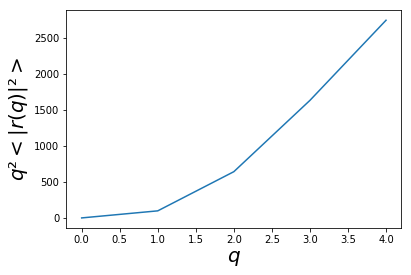

In [15]:
plt.plot(r_q_pow_ave*q**2)

plt.xlabel('$q$',fontsize=20)
plt.ylabel('$q²<|r(q)|²>$',fontsize=20)
plt.savefig(path_res+'plot_linetension'+name+'.pdf', format='pdf',bbox_inches='tight')